# SLIP

## a Simple Library for Image Processing


Table of content

* [What is the SLIP package?](#What-is-the-SLIP-package?) 
* [Installing](#Install) 
* [Importing the library](#Importing-the-library)
* [Filtering](#Filtering) 
* [Whitening](#Whitening) 
* [checking basic translation mechanism](#checking-basic-translation-mechanism)
* [testing cropping](#testing-cropping)
* [Handling a database](#Handling-a-database)
* [An application: statistics of natural images](#An-application:-statistics-of-natural-images)


## What is the SLIP package?

The ``SLIP`` library defines a simple object-oriented class for image processing. Use it to create a SLIP object with a dedicated image size (and optionnaly some other useful parameters) - which you can use to apply common image processing routines to your images.

In [15]:
from SLIP import Image
im = Image({'N_X':128, 'N_Y':128})

This library collects different Image Processing tools for use with the ``LogGabor`` and ``SparseEdges`` libraries.

Fork me on https://github.com/meduz/SLIP !

This library is used in other projects; for more information check respective pages @ http://pythonhosted.org/LogGabor and http://pythonhosted.org/SparseEdges

[Back to top](#SLIP)

## Installing

Requirements :

* numpy
* scipy
* NeuroTools
* ipython
* matplotlib

To install them, use

    pip install -U -r requirements.txt
    
Install using pip:

    pip install -U SLIP

In [16]:
!pip install -U .

Processing /Users/lolo/Dropbox/science/SLIP
  Found existing installation: SLIP 0.1
    Uninstalling SLIP-0.1:
      Successfully uninstalled SLIP-0.1
  Running setup.py install for SLIP


[Back to top](#SLIP)

## Importing the library

In [17]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 8
figsize=(fig_width, .618*fig_width)
fopts = {'fontsize':18}

In [18]:
from NeuroTools.parameters import ParameterSet
pe = ParameterSet({'N_X':128, 'N_Y':128})
from SLIP import Image

In [19]:
im = Image(pe)
print(im.__doc__)


    Collects image processing routines for one given image size:
     - Some classical related to pure Fourier number crunching:
        - creating masks
        - normalize,
        - fourier_grid : defines a useful grid for generating filters in FFT
        - show_FT : displays the envelope and impulse response of a filter
        - invert : go to the other of the fourier transform
    - Some usual application of Fourier filtering:
        - trans : translation filter in Fourier space
        - whitening procedures
     - Some related to handling experiments:
        - load_in_database : loads a random image in a folder and
        - patch : takes a random patch of the correct size
    


[Back to top](#SLIP)

## Filtering

Using the ``FTfilter`` function, it is easy to filter an image with a filter defined in Fourier space.

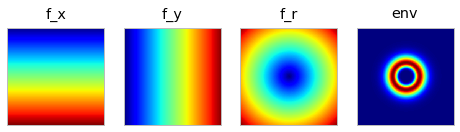

In [20]:
from NeuroTools.parameters import ParameterSet
pe = ParameterSet('default_param.py')
from SLIP import Image
sf_0 = 0.15
B_sf = 0.05
theta_0 = np.pi/2
B_theta = 0.15
loggabor = True

def envelope_orientation(im, theta_0=theta_0, B_theta=B_theta, norm=True):
    theta = np.arctan2(im.f_x, im.f_y)
    env =  np.exp(np.cos(2*(theta-theta_0))/B_theta**2)
    if norm: env /= np.sqrt((env**2).sum())
    return env

def envelope_radial(im, sf_0=sf_0, B_sf=B_sf, loggabor=loggabor, norm=True):
    if sf_0 == 0.: return 1.
    if loggabor:
        env = 1./im.f*np.exp(-.5*(np.log(im.f/sf_0)**2)/(np.log((sf_0+B_sf)/sf_0)**2))
        if norm: env /= np.sqrt((env**2).sum())
        return env
    else:
        return np.exp(-.5*(im.f - sf_0)**2/B_sf**2)

im = Image(pe)
env = envelope_radial(im)

fig, ax = plt.subplots(1, 4, figsize=figsize)
for i, (f, label) in enumerate(zip([im.f_x, im.f_y, im.f, env], ['f_x', 'f_y', 'f_r', 'env'])):
    ax[i].matshow(f)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

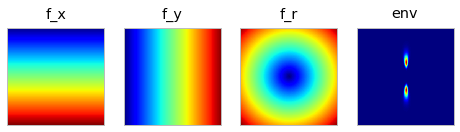

In [21]:
env = envelope_radial(im) * envelope_orientation(im)

fig, ax = plt.subplots(1, 4, figsize=figsize)
for i, (f, label) in enumerate(zip([im.f_x, im.f_y, im.f, env], ['f_x', 'f_y', 'f_r', 'env'])):
    ax[i].matshow(f)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

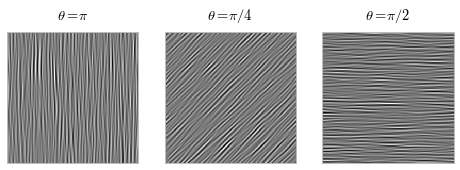

In [22]:
# one can then easily generate a texture
theta0 = np.pi/2
Btheta = 0.15
theta_0 = [0, np.pi/4, np.pi/2]
B_theta = [0.1, 0.5, 1.]

def texture(env):
 return np.fft.fft2(np.fft.ifftshift(env * np.exp(1j * 2 * np.pi * np.random.rand(env.shape[0], env.shape[1])))).real

def impulse(env, phi=2 * np.pi):
    I = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(env * np.exp(1j * phi))).real)
    I /= env.sum()
    return I

fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (theta0_, label) in enumerate(zip(theta_0, [r'$\theta = \pi$', r'$\theta = \pi/4$', r'$\theta = \pi/2$']) ) :
    env = envelope_radial(im) * envelope_orientation(im, theta_0=theta0_, B_theta=Btheta)
    I = texture(env)
    ax[i].matshow(I, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
#plt.tight_layout()
fig.savefig('figures/realisation_MC_theta0(week4).pdf')

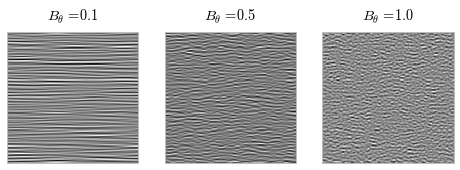

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (Btheta_, label) in enumerate(zip(B_theta, [r'$B_\theta = 0.1$', r'$B_\theta = 0.5$', r'$B_\theta = 1.0$']) ) :
    env = envelope_radial(im) * envelope_orientation(im, theta_0=theta0, B_theta=Btheta_)
    I = texture(env)
    ax[i].matshow(I, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
#plt.title(u'Réalisation du Motion Clouds')
#plt.tight_layout()
fig.savefig('figures/realisation_MC_Btheta(week4).pdf')

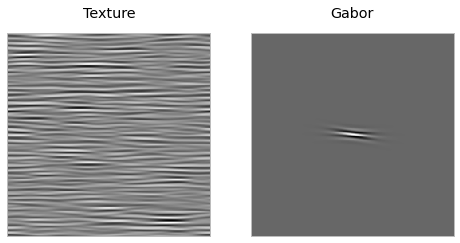

In [24]:
env_in = envelope_radial(im) * envelope_orientation(im)
env_V1 = envelope_radial(im) * envelope_orientation(im, theta_0=np.random.rand()*np.pi)

fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1)], [u'Texture', u'Gabor'])):
    ax[i].matshow(f, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])    

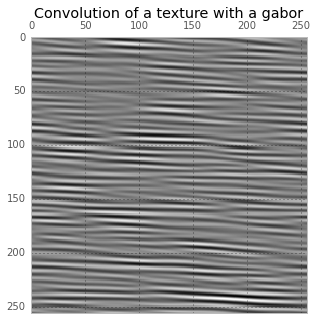

In [25]:
def convolve(image_in, image_V1):
    env_in = np.fft.fft2(image_in)
    env_V1 = np.fft.fft2(image_V1)
    return np.fft.fftshift(np.fft.ifft2((env_in*env_V1)).real)

R = convolve(texture(env_in), impulse(env_V1))
fig, ax = plt.subplots(figsize=figsize)
ax.matshow(R, cmap=plt.cm.gray)
plt.title(u"Convolution of a texture with a gabor")

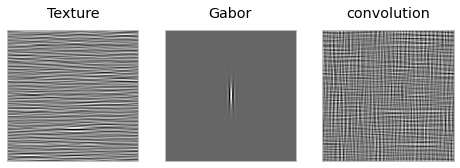

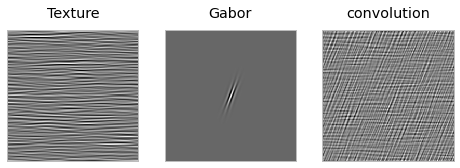

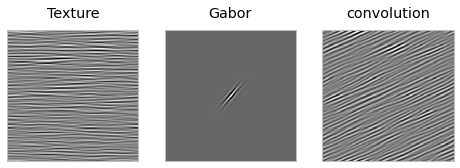

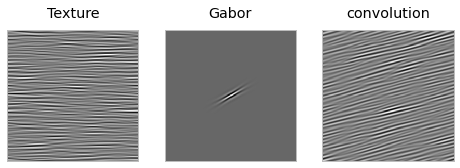

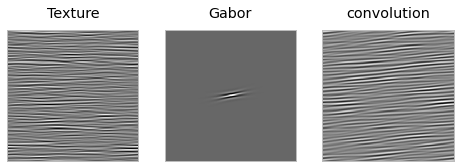

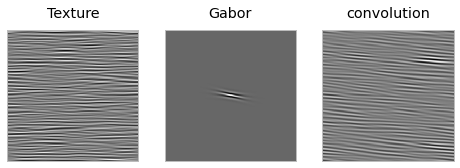

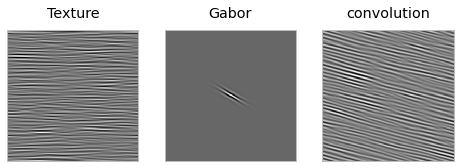

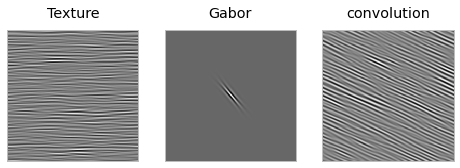

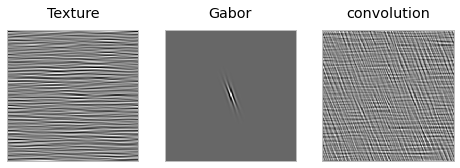

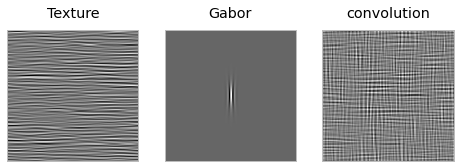

In [26]:
# images des convolutions avec différents angles
N_theta=360
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, 10)

for i, theta0_ in enumerate(theta_0) :
    env_in = envelope_radial(im) * envelope_orientation(im)
    env_V1 = envelope_radial(im) * envelope_orientation(im, theta_0=theta0_)
    R = convolve(texture(env_in), impulse(env_V1))
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1), R], [u'Texture', u'Gabor', u'convolution'])):
        ax[i].matshow(f, cmap=plt.cm.gray)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

[Back to top](#SLIP)

## Whitening

In [27]:
print(im.whitening_filt.__doc__)


        Returns the average correlation filter in FT space.

        Computes the average power spectrum = FT of cross-correlation, the mean decorrelation
        is given for instance by (Attick, 92).

        


Testing the whitening strategy.

Generates 2 figures:

* one which compares Olshausen's formulation and the actual statistical measure
* one which shows the actual effect of whitening


In [28]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 16
figsize=(fig_width, .618*fig_width)
fopts = {'fontsize':18}

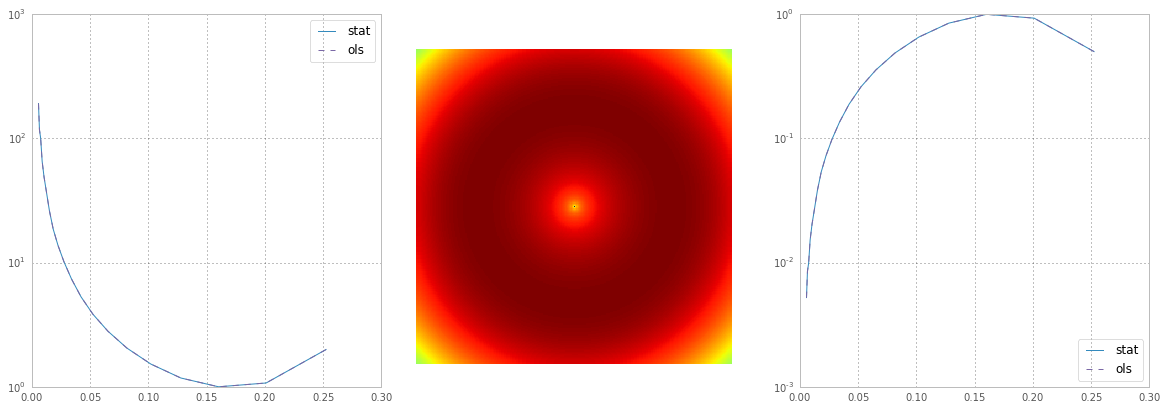

In [29]:
from SLIP import Image

from NeuroTools.parameters import ParameterSet
pe = ParameterSet('default_param.py')

def radial_frequency(F):
    N_f = 20 #F.shape[0]/2 # making an histogram with N_f bins
    f_bins = np.linspace(0., 0.5, N_f+1)
    f_bins = np.logspace(-2., 0, N_f+1, base=10)*0.5

    N_orientations = 24 # making an histogram with N_f bins
    theta_bins = np.linspace(0, np.pi, N_orientations, endpoint=False)

    F_rot = np.zeros((N_f, N_orientations))
    for i_theta in range(N_orientations):
        for i_f in range(N_f):
            f_slice = (f_bins[i_f] < im.f) *  ( im.f < f_bins[i_f+1])
            theta_slice = np.exp(np.cos(im.f_theta - theta_bins[i_theta])/(1.5*2*np.pi/N_orientations)**2)
            F_rot[i_f, i_theta] = (f_slice * theta_slice * F).sum()
            F_rot[i_f, i_theta] /= (f_slice * theta_slice).sum() # normalize by the integration area (numeric)
    if np.isnan(F_rot).any(): print('Beware of the NaNs!')
    F_rot /= F_rot.max()
    return f_bins, theta_bins, F_rot

def plot_whitening_filters():
    pe = ParameterSet('default_param.py')
    im = Image(pe)

    K = im.whitening_filt()
    f_bins, theta_bins, K_rot = radial_frequency(K)
    f_bins_m = .5*(f_bins[:1]+f_bins[1:])
    im.pe.learn = False
    K_ols = im.whitening_filt()
    f_bins, theta_bins, K_ols_rot = radial_frequency(K_ols)

    fig = plt.figure(figsize=(fig_width, fig_width/3))
    bord = 0.03
    a = plt.axes([bord, bord, 1/3.-bord,  1-bord])
    a.semilogy(f_bins_m, 1/K_rot.mean(axis=1),c='b', label='stat')
    a.semilogy(f_bins_m, 1/K_ols_rot.mean(axis=1), c='k', ls='--', label='ols')
    a.legend(loc="upper right")

    a = plt.axes([1/3.+bord, bord, 1/3.-2*bord , 1. -2*bord])
    a.matshow(np.log(K))
    a.axis('off')

    a = plt.axes([2/3.+bord, bord, 1/3.-bord, 1-bord])
    a.semilogy(f_bins_m, K_rot.mean(axis=1),c='b', label='stat')
    a.semilogy(f_bins_m, K_ols_rot.mean(axis=1), c='k', ls='--', label='ols')
    a.legend(loc="upper right")
    a.legend(loc="lower right")

plot_whitening_filters()


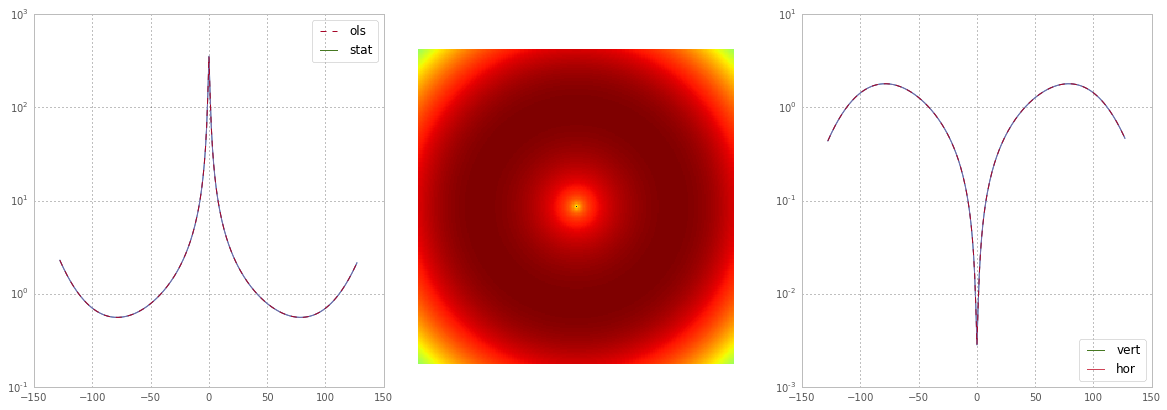

In [30]:
from SLIP import Image

from NeuroTools.parameters import ParameterSet
pe = ParameterSet('default_param.py')
im = Image(pe)
im.pe.recompute = True
# TODO: know what N means : figure 3 ?

im.pe.learn = True
K = im.whitening_filt()
bord = .03

middle = np.ceil(K.shape[0]/2)
K_axis= np.arange(-middle,middle)
vec = .5 * (K[middle,:] + K[middle+1,:])
hor = .5 * (K[:,middle] + K[:,middle+1])

im.pe.learn = False
K_ols = im.whitening_filt()
#K_ols = im.olshausen_whitening_filt()
vec_ols = .5 * (K_ols[middle,:] + K_ols[middle+1,:])

#axes(rect, axisbg='w') where rect=[left, bottom, width, height] in
#normalized (0,1) units.  axisbg is the background color for the
#axis, default white

fig = plt.figure(figsize=(fig_width, fig_width/3))
a = plt.axes([bord, bord, 1/3.-bord,  1-bord])
a.semilogy(K_axis, 1/vec,c='b')
a.semilogy(K_axis, 1/hor,c='g')
a.semilogy(K_axis, 1/vec_ols, c='k', ls='--', label='ols')
a.semilogy([], c='k', ls='-', label='stat')
a.legend(loc="upper right")

a = plt.axes([1/3.+bord, bord, 1/3.-2*bord , 1. -2*bord])
a.matshow(np.log(K))
a.axis('off')

a = plt.axes([2/3.+bord, bord, 1/3.-bord, 1-bord])
a.semilogy(K_axis, vec,c='b')
a.semilogy(K_axis, hor,c='g')
a.semilogy(K_axis, vec_ols,c='k', ls='--')
a.semilogy([], c='b', label='vert')
a.semilogy([], c='g', label='hor')
a.legend(loc="lower right")

0%  100%
[]

 Testing that whitening effectively works... 
Title: 
  Started: 04/07/2015 12:55:38
  Finished: 04/07/2015 12:55:38
  Total time elapsed: 0.000 sec
Figure whitening
 Testing that whitening effectively works... 

0%  100%
[]


Title: 
  Started: 04/07/2015 12:55:38
  Finished: 04/07/2015 12:55:38
  Total time elapsed: 0.000 sec
Figure whitening
 Testing that whitening effectively works... 

0%  100%
[]


Title: 
  Started: 04/07/2015 12:55:38
  Finished: 04/07/2015 12:55:38
  Total time elapsed: 0.000 sec
Figure whitening


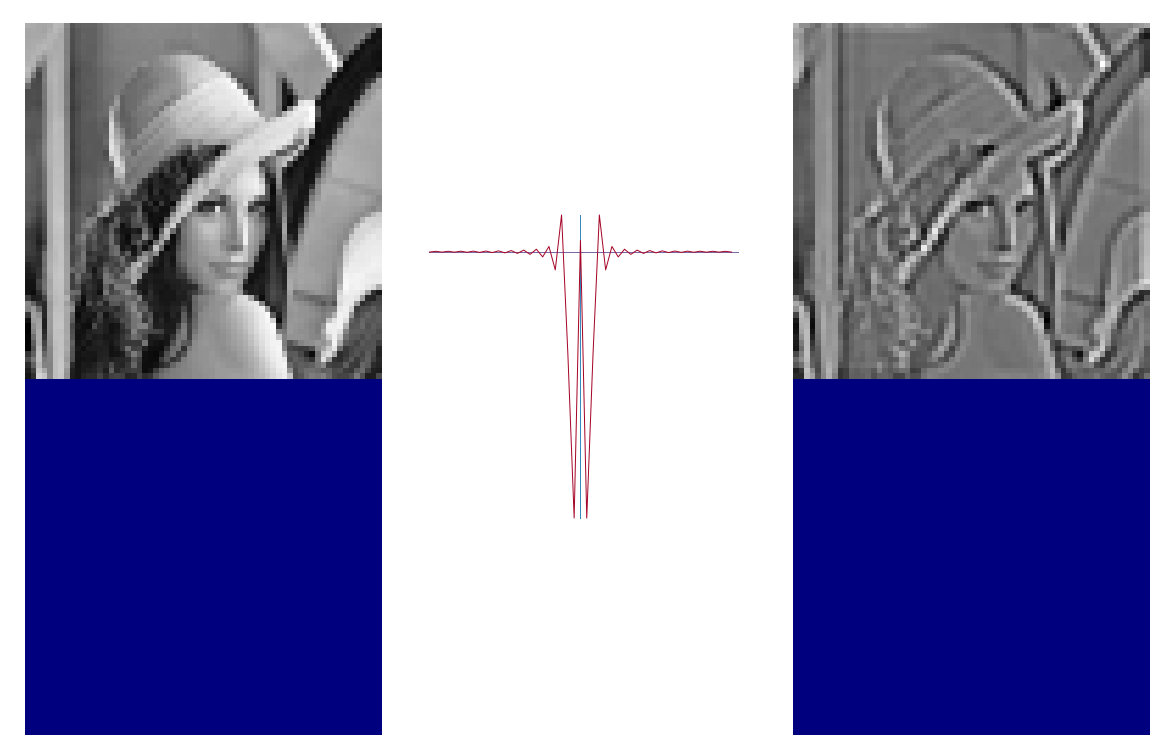

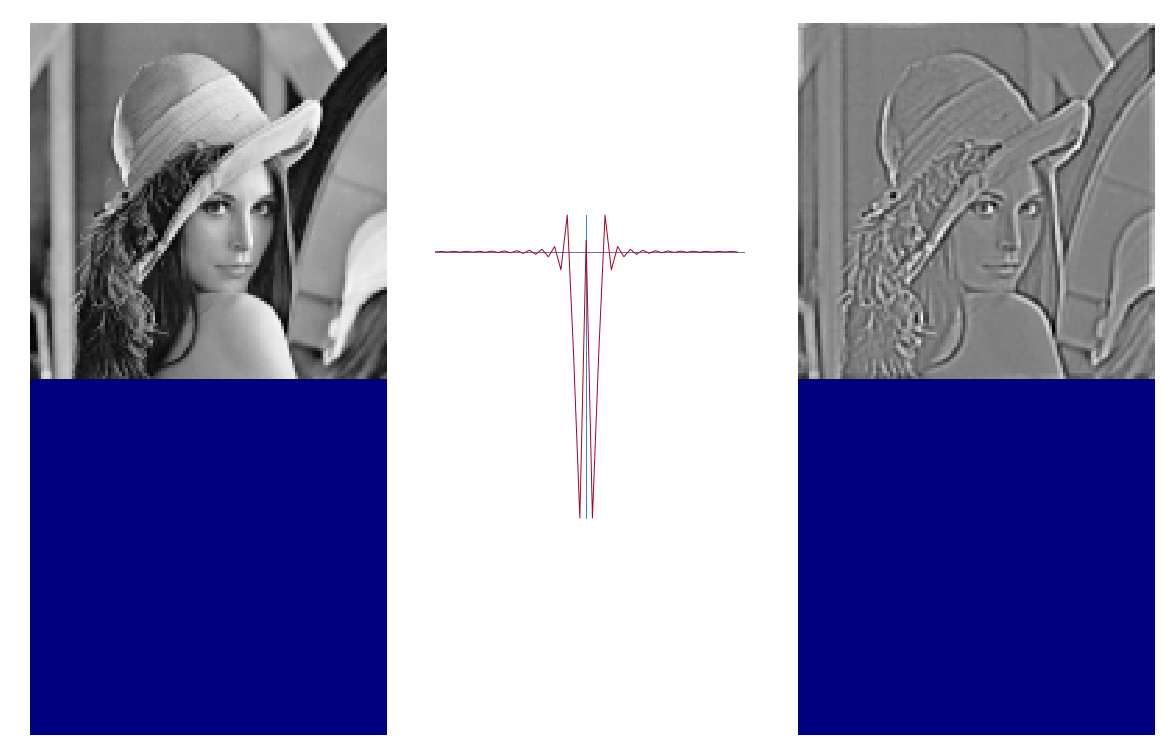

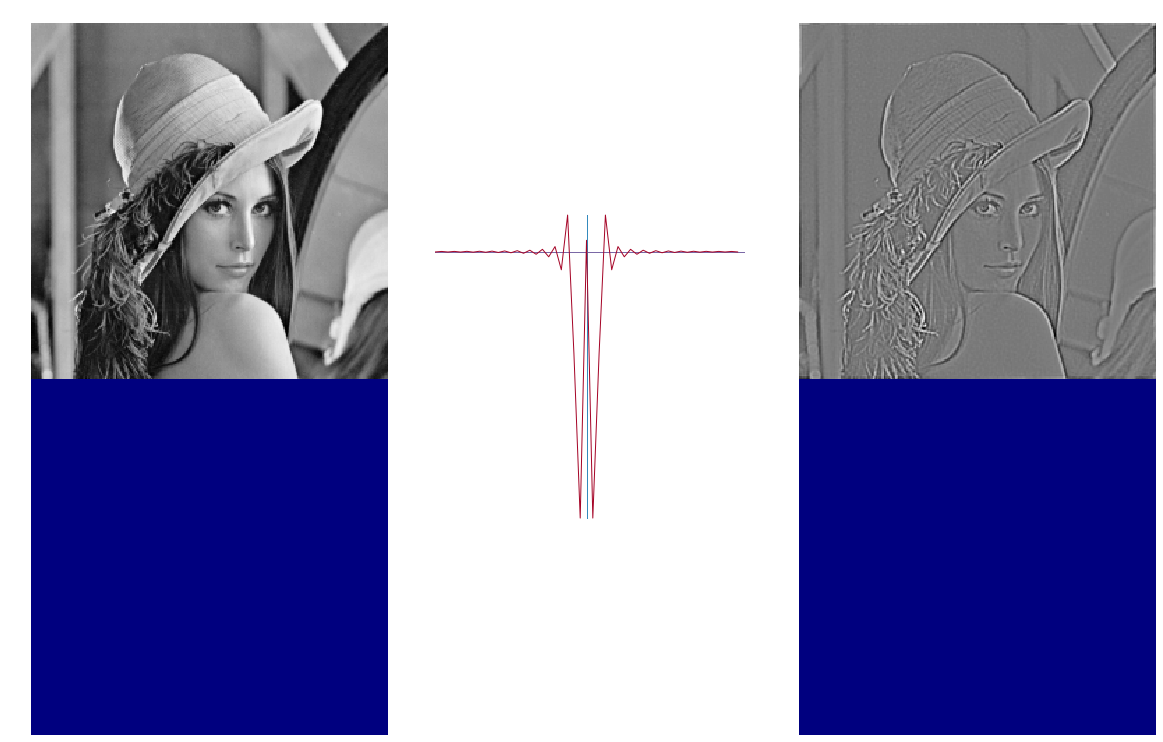

In [31]:
import pyprind 
for size in [64, 128, 256]:
    image = plt.imread('database/lena' +np.str(size) + '.png').mean(axis=-1)

    print(' Testing that whitening effectively works... ')
    pe.N_X = size
    pe.N_Y = size
    im_patch = Image(pe)
    xcorr, xcorr_white = np.zeros((pe.N_X, pe.N_Y)), np.zeros((pe.N_X, pe.N_Y))
    bar = pyprind.ProgBar(im.pe.white_n_learning, width=100)
    for i_learning in range(im.pe.white_n_learning):
        image_patch, filename, croparea = im_patch.patch(im.pe.name_database, verbose=False)
        xcorr += im_patch.coco(image_patch, image_patch)/im.pe.white_n_learning
        image_patch = im_patch.whitening(image_patch)
        xcorr_white += im_patch.coco(image_patch, image_patch)/im.pe.white_n_learning
        bar.update()
    print(bar)

    middle = np.ceil(K.shape[0]/2)
    print('Figure whitening')
    fig = plt.figure(figsize=(fig_width, .618*fig_width))
    bord = .03
    # top left
    a = plt.axes([0,  1/2., 1/3., 1/2.])
    a.matshow(image, cmap=plt.gray())
    a.axis('off')
    # top right
    a = plt.axes([2/3., 1/2., 1/3., 1/2.])
    white = im_patch.whitening(image)
    a.matshow(white, cmap=plt.gray())
    a.axis('off')
    # middle
    a = plt.axes([1/3.+bord, .25, 1/3.-2*bord , 1/2.])
    impulse = np.zeros(image.shape)#(25,25))
    impulse[24,24] = 1
    K = im_patch.whitening(impulse)[:49,:49]
    middle = np.ceil(K.shape[0]/2)
    K_middle = .5 * (K[middle,:] + K[middle+1,:])
    a.plot([24,24],[np.min(K_middle), np.max(K_middle)], c='k')
    a.plot([0, 49],[0,0], c='k')
    a.plot(K_middle, c='b')
    a.axis('off')
    # bottom left
    a = plt.axes([0,  0, 1/3., 1/2.])
    a.matshow(xcorr, cmap=plt.jet())#
    a.axis('off')
    #bottom right
    a = plt.axes([2/3., 0, 1/3., 1/2.])
    a.matshow(xcorr_white, cmap=plt.jet())
    a.axis('off')


Figure Atick


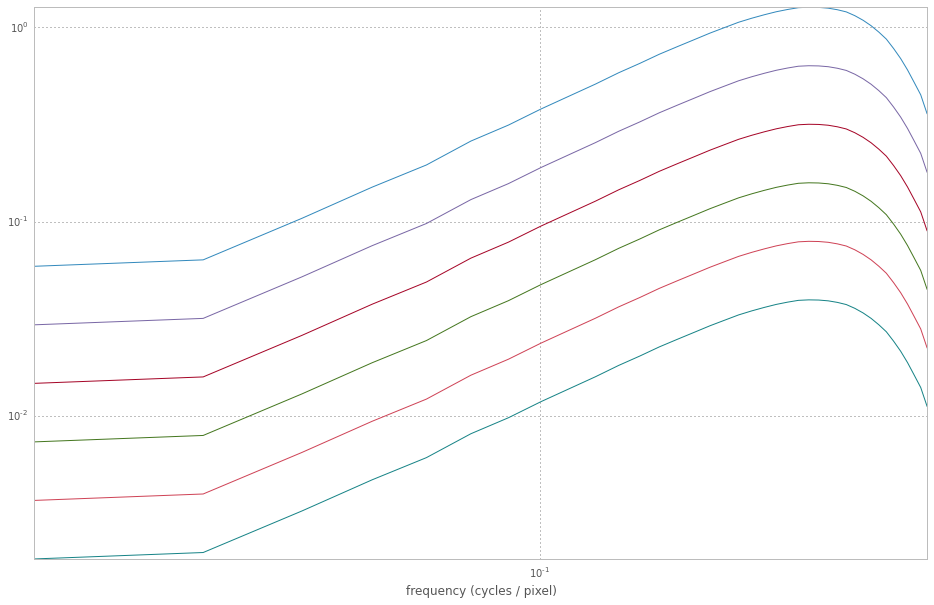

In [32]:
""" This is just to remember that we use a simpler fitering technique.

In the Attick LGN, the gain is changed according to an estimation of the SNR.

"""
print('Figure Atick')
image = plt.imread('database/lena256.png')[:,:,0]

contrasts = 1. / 2**np.arange(6)
freqs = np.linspace(0.,.49, 40)
size  = image.shape
x, y = np.mgrid[0:size[0],0:size[1]]

response = np.zeros((len(freqs), len(contrasts)))
for i_contrast, contrast in enumerate(contrasts):
    for i_freq, freq in enumerate(freqs):
        image = contrast * np.sin( 2* np.pi * x * freq)
        white = im.whitening(image)
        response[i_freq,i_contrast] = np.std(white)
response.shape

fig = plt.figure(figsize=(fig_width, 0.618*fig_width))
a = plt.subplot(111)
a.loglog(freqs,response,c='b')
plt.xlabel('frequency (cycles / pixel)')
_ = plt.axis('tight')

[Back to top](#SLIP)

## checking basic translation mechanism

defining a reference test image; check the axis labels for a (x,y) translation

In [33]:
debug = True
debug = False
#! this test report is about the Image class:
if debug:
    pe.N_X = 2**6
else:
    pe.N_X = 2**8
pe.N_Y = pe.N_X
N_X, N_Y = pe.N_X, pe.N_Y
opts= {'cmap': plt.cm.gray, 'vmin':-1., 'vmax':1., 'interpolation':'nearest', 'origin':'upper'}#, 'figsize':(16,4)}

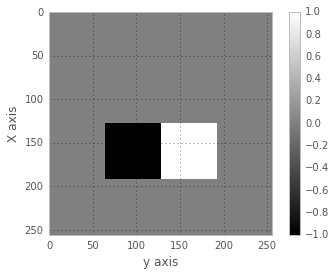

In [34]:
im = Image(pe)
image = np.zeros((N_X, N_Y))
image[N_X/2:N_X/2+N_X/4, N_X/2:N_X/2+N_X/4] = 1 # white square on the right
image[N_X/2:N_X/2+N_X/4, N_X/4:N_X/2] = -1  # black square on the left
plt.imshow(image, **opts)
plt.ylabel('X axis')
plt.xlabel('y axis')
plt.colorbar()

translating the image by an integer by rolling indices


32.0 64.0


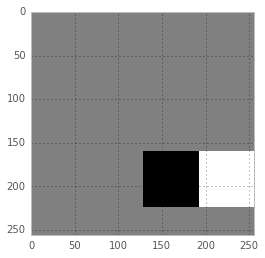

In [35]:
print(N_X/8., N_Y/4.)
plt.imshow(np.roll(np.roll(image, np.int(N_X/8.), axis=0), np.int(N_X/4.), axis=1), **opts)

(remember axis of imshow shox x going down, y going right)

translating the image down

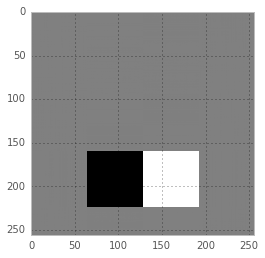

In [36]:
plt.imshow(im.translate(image, [N_X/8., 0.]), **opts)

translating the image right

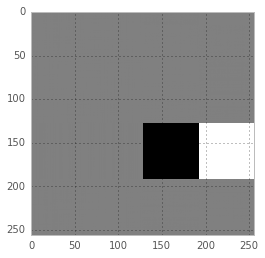

In [37]:
plt.imshow(im.translate(image, [0., N_Y/4.]), **opts)

translating the image on both axis

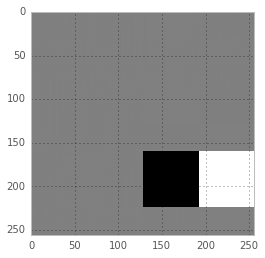

In [38]:
plt.imshow(im.translate(image, [N_X/8., N_Y/4.]), **opts)

translating the image over the torus

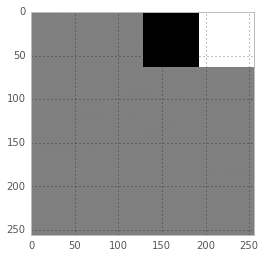

In [39]:
plt.imshow(im.translate(image, [N_X/2., N_Y/4.]), **opts)

[Back to top](#SLIP)

## some checks that should produce gray images (= null error)

null translation gives the same image

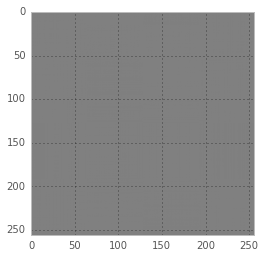

In [40]:
plt.imshow(image - im.translate(image, [0., 0.]), **opts)

the lg.translate function is invertible

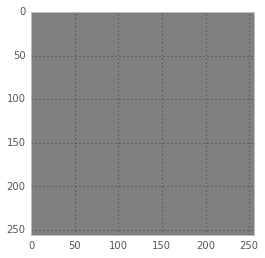

In [41]:
plt.imshow(image - im.translate(im.translate(image, [1.64, -2.233]), [-1.64, 2.233]), **opts)
#plt.colorbar()

also true for bigger translations  (we separate integer part from fractional part in the translation)

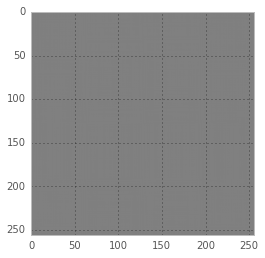

In [42]:
plt.imshow(image - im.translate(im.translate(image, [182.64, -286.233]), [-182.64, 286.233], preshift=True), **opts)

but not always true when we don't separate

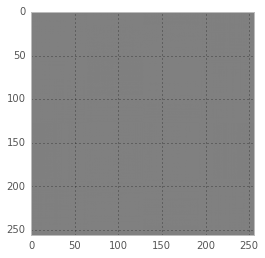

In [43]:
plt.imshow(image - im.translate(im.translate(image, [182.64, -286.233]), [-182.64, 286.233], preshift=False), **opts)

the lg.translate function is periodic

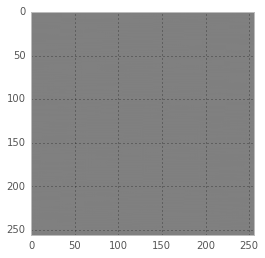

In [44]:
plt.imshow(image - im.translate(image, [-45*N_X, 5*N_Y]), **opts)

lg.translate function is associative

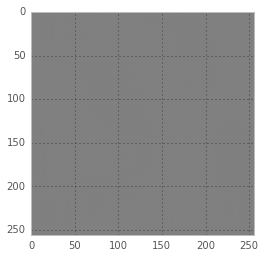

In [45]:
plt.imshow(im.translate(image, [1., .0]) - im.translate(im.translate(image, [.5, .0]), [.5, .0]), **opts)

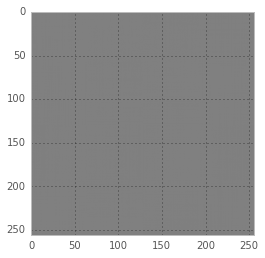

In [46]:
plt.imshow(im.translate(image, [2., .0]) - im.translate(im.translate(image, [1.5, -1.0]), [.5, 1.0]), **opts)

[Back to top](#SLIP)

## defining input image as Lena

In [47]:
image = plt.imread('database/lena256.png').mean(axis=-1)
print(image.mean(), image.std())
pe.N_X, pe.N_Y = image.shape
N_X, N_Y = pe.N_X, pe.N_X
im = Image(pe)
image = im.normalize(image, center=False)
print(image.mean(), image.std())
image = im.normalize(image, center=True)
print(image.mean(), image.std())

0.501803 0.180984
0.539914 0.19473
-5.7742e-08 0.423248


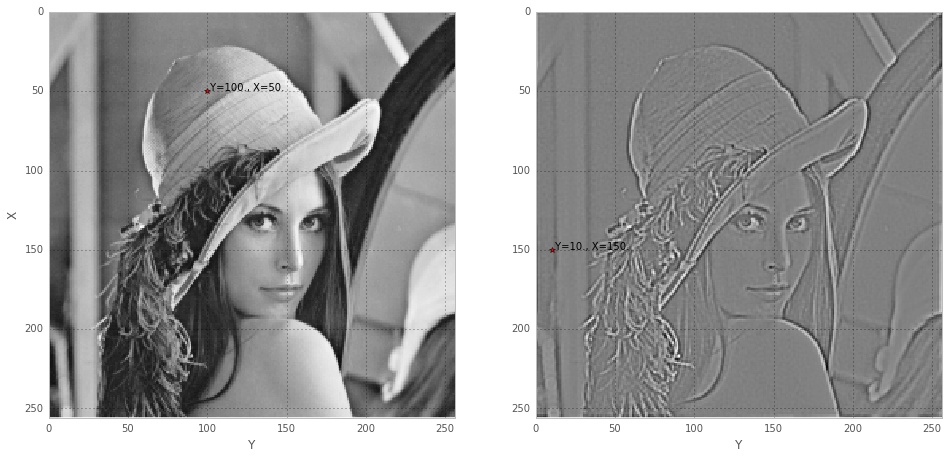

In [48]:
fig = plt.figure(figsize=figsize)
a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)
a1.imshow(im.normalize(image, center=True, use_max=True), **opts)
a1.set_xlabel('Y'), a1.set_ylabel('X')
a1.plot([100.], [50.], 'r*')
a1.text(100., 50., ' Y=100., X=50.')
a1.axis([0, image.shape[0], image.shape[1], 0])
a2.imshow(im.normalize(im.whitening(image), center=True, use_max=True), **opts)
a2.plot([10.], [150.], 'r*')
a2.text(10., 150., ' Y=10., X=150.')
a2.set_xlabel('Y')
v = a2.axis([0, image.shape[0], image.shape[1], 0])

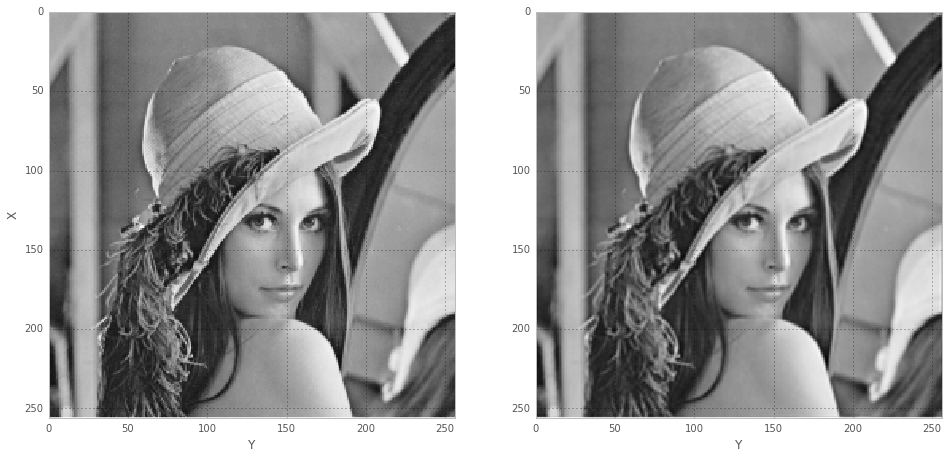

In [49]:
fig = plt.figure(figsize=figsize)
a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)
a1.imshow(im.normalize(image, center=True, use_max=True), **opts)
a1.set_xlabel('Y'), a1.set_ylabel('X')
a1.axis([0, image.shape[0], image.shape[1], 0])
a2.imshow(im.normalize(im.dewhitening(im.whitening(image)), center=True, use_max=True), **opts)
a2.set_xlabel('Y')
v = a2.axis([0, image.shape[0], image.shape[1], 0])

[Back to top](#SLIP)

## testing import and cropping

Using image  M_N415038.jpg
Cropping @ [left, right, bottom, top]:  [21, 149, 14, 142]


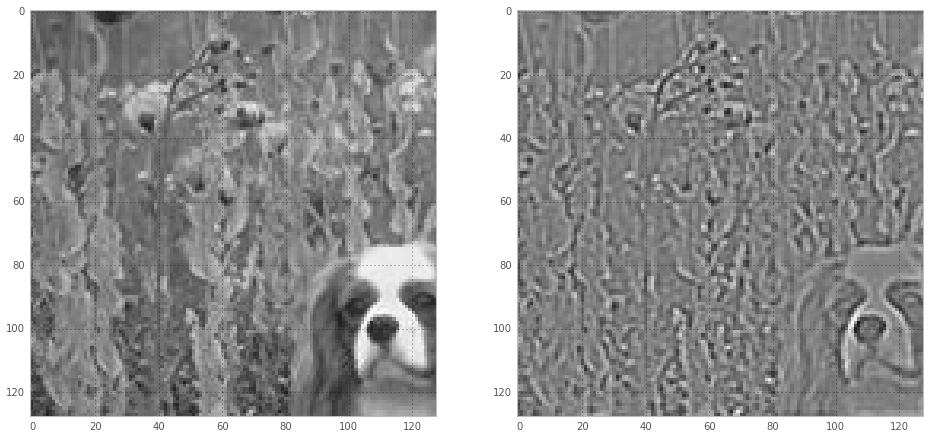

Using image  F_N408047.jpg
Cropping @ [left, right, bottom, top]:  [43, 171, 120, 248]


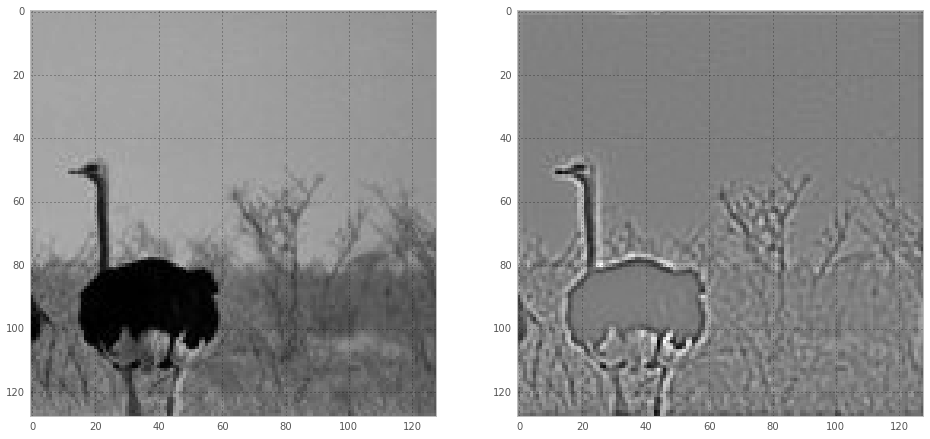

Using image  B_N106014.jpg
Cropping @ [left, right, bottom, top]:  [113, 241, 95, 223]


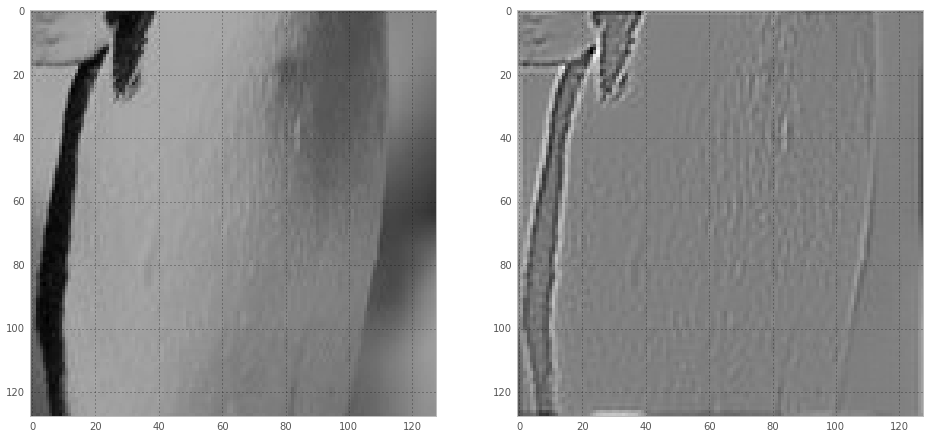

Using image  B_N43027.jpg
Cropping @ [left, right, bottom, top]:  [42, 170, 45, 173]


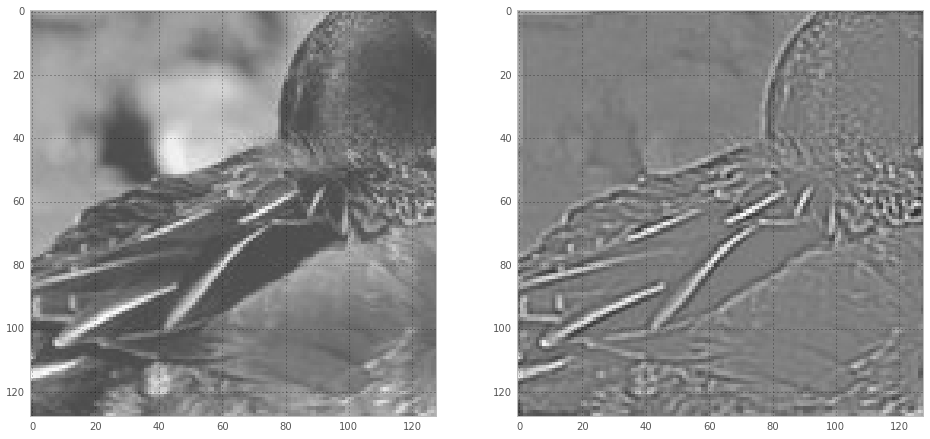

Using image  Hda_obj298.jpg
Cropping @ [left, right, bottom, top]:  [22, 150, 46, 174]


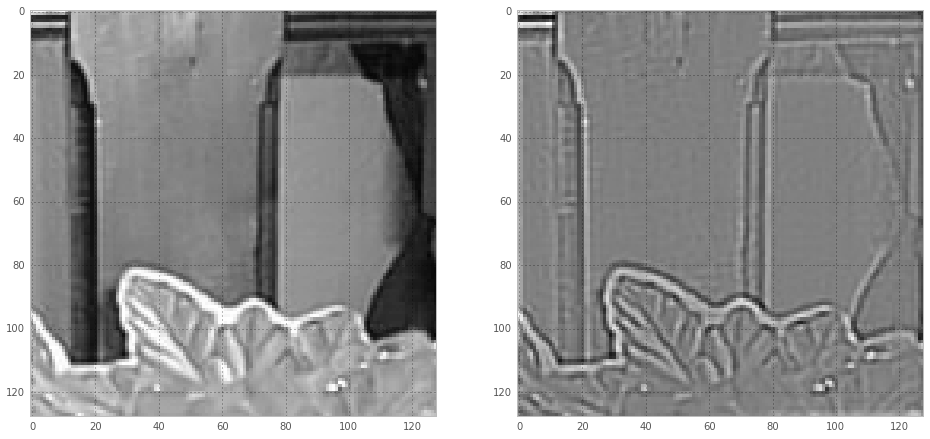

Using image  Fdn_natu139.jpg
Cropping @ [left, right, bottom, top]:  [36, 164, 25, 153]


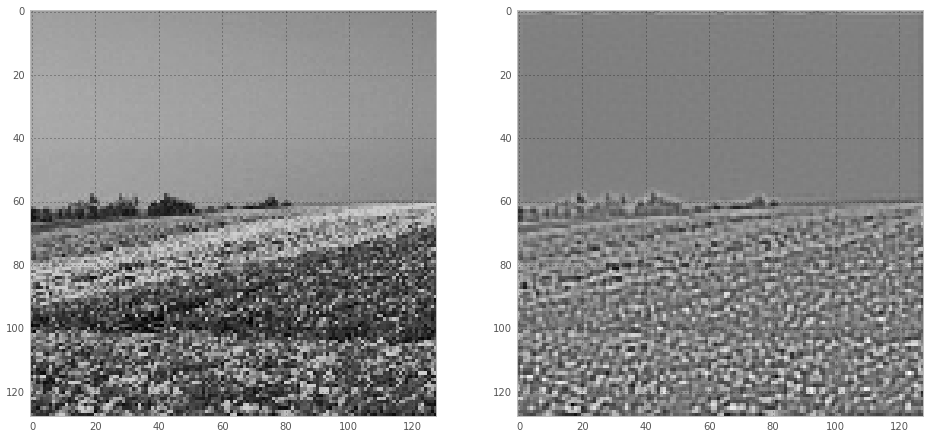

Using image  Mda_art573.jpg
Cropping @ [left, right, bottom, top]:  [44, 172, 8, 136]


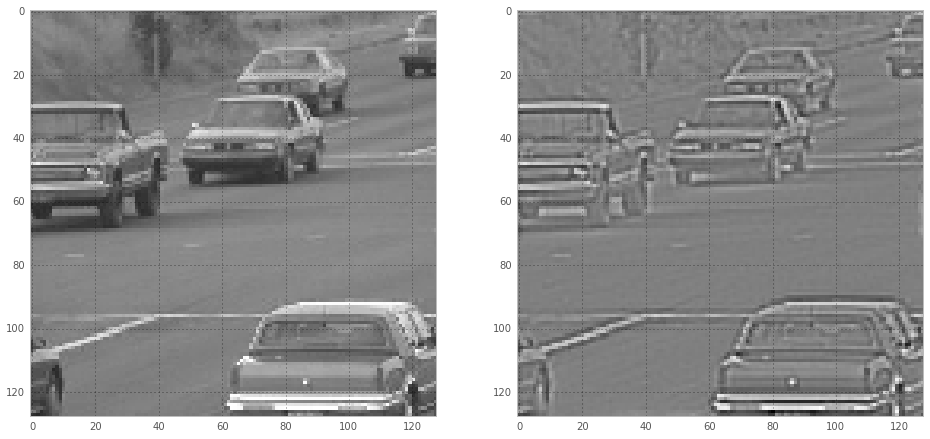

Using image  Mdn_natu462.jpg
Cropping @ [left, right, bottom, top]:  [67, 195, 23, 151]


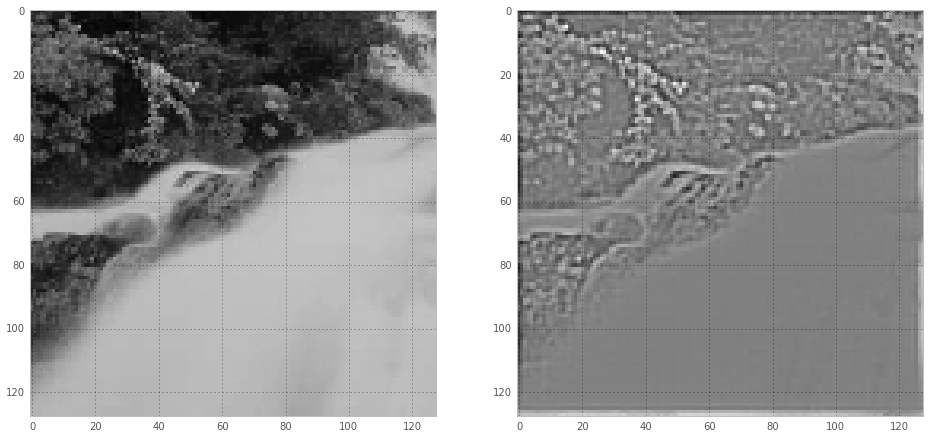

In [50]:
axs = []
pe.N_X = 128
pe.N_Y = pe.N_X
pe.datapath = '../AssoField/database/'
im = Image(pe)
for name_database in ['serre07_targets', 'serre07_distractors']:
    for _ in range(4):
        fig = plt.figure(figsize=figsize)
        image, filename, croparea = im.patch(name_database, )
        axs.append(fig.add_subplot(1, 2, 1))
        axs[-1].imshow(im.normalize(image, center=True, use_max=True), **opts)
        axs.append(fig.add_subplot(1, 2, 2))
        axs[-1].imshow(im.normalize(im.whitening(image), center=True, use_max=True), **opts)
        plt.show()

## Handling a database

In [52]:
print(im.make_imagelist.__doc__)
# extract one image list from a database
imagelist = im.make_imagelist('serre07_targets')
print('Number of images:', len(imagelist))


        makes a list of images with no repetition.
        
Number of images: 600


In [53]:
print(im.get_imagelist.__doc__)
pe.N_X = 128 # size of patches
pe.datapath = '../AssoField/database/'
im = Image(pe)
# remove any existing one
!ls -l mat/classifier_serre07_targets_images.pickle
!rm -f mat/classifier_serre07_targets_images.pickle
# store one image list from a database
imagelist = im.get_imagelist('classifier', 'serre07_targets') 

None
-rw-r--r-- 1 lolo staff 37284 Jan 13 11:52 mat/classifier_serre07_targets_images.pickle


INFO:SLIP:There is no imagelist, creating one: [Errno 2] No such file or directory: 'mat/classifier_serre07_targets_images.pickle' 
INFO:SLIP: > setting up image list for serre07_targets 


NameError: name 'file' is not defined

In [54]:
# now we can access again this stored list
!ls -l mat/classifier_serre07_targets_images.pickle
imagelist = im.get_imagelist('classifier', 'serre07_targets')

ls: cannot access mat/classifier_serre07_targets_images.pickle: No such file or directory


INFO:SLIP:There is no imagelist, creating one: [Errno 2] No such file or directory: 'mat/classifier_serre07_targets_images.pickle' 
INFO:SLIP: > setting up image list for serre07_targets 


NameError: name 'file' is not defined

[Back to top](#SLIP)

## An application: statistics of natural images

In [58]:
from holoviews import SheetView, SheetStack
%load_ext dataviews.ipython

ImportError: cannot import name 'SheetView'

In [59]:
%view 200 pdf
%opts Phase_SheetView cmap='hsv'
%opts Radial_SheetView cmap='hot'
%opts Phase_SheetView clims=(-1., 1.)
%opts Radial_SheetView clims=(0, 1.)
%opts SheetView cmap='hot' 
s_f = SheetView(im.f, label='Radial', title="{label} frequency", dimensions=[r'$f_x$', r'$f_y$']).hist()
s_theta = SheetView(im.f_theta/np.pi, label='Phase', title="{label} frequency", dimensions=[r'$f_x$', r'$f_y$']).hist()
s_f + s_theta

ERROR: Line magic function `%view` not found.
ERROR: Line magic function `%opts` not found.
ERROR: Line magic function `%opts` not found.
ERROR: Line magic function `%opts` not found.
ERROR: Line magic function `%opts` not found.
ERROR: Line magic function `%opts` not found.


NameError: name 'SheetView' is not defined

In [60]:
pe = ParameterSet('default_param.py')
pe.N_X, pe.N_Y = 128, 128 # size of patches
pe.datapath = '../AssoField/database/'
im = Image(pe)
name_database = 'serre07_targets'
imagelist = im.make_imagelist(name_database=name_database)

In [61]:
F = np.zeros_like(im.f_x)
for filename, croparea in imagelist:
    image, filename_, croparea_ = im.patch(name_database, filename=filename, croparea=croparea, center=False)
    F += np.fft.fftshift(np.absolute(np.fft.fftn(image))**2)
F /= F.max()

In [62]:
#fig, axs = plt.subplots(1, 1, figsize=(13, 13))
#axs.contourf(im.f_x[0, :], im.f_y[0, :], np.log(F).T, cmap=plt.hot())
#axs.pcolor(im.f_x, im.f_y, np.log(F), cmap=plt.hot())
#axs.axis('tight')
#axs.set_xlabel('radial frequency')
#_ = axs.set_ylabel('temporal frequency')
SheetView(np.log(F), label='average spectral energy', dimensions=[r'$f_x$', r'$f_y$']).hist()

NameError: name 'SheetView' is not defined

In [63]:
print('F is maximum at :', np.unravel_index(np.argmax(F), dims=F.shape), ' (we expected (', F.shape[0]/2, ', ', F.shape[0]/2, ') )')

F is maximum at : (64, 64)  (we expected ( 64.0 ,  64.0 ) )


We now try to fit a power-law to one slice:

In [64]:
from lmfit.models import PowerLawModel
mod = PowerLawModel()
valid = -(np.arange(F.shape[0])==F.shape[0]/2)
pars = mod.guess(F[valid, F.shape[0]/2], x=np.abs(im.f_x[valid, F.shape[0]/2]))
out  = mod.fit(F[valid, F.shape[0]/2], pars, x=np.abs(im.f_x[valid, F.shape[0]/2]))
print(out.fit_report(min_correl=0.25))

valid = -(np.arange(F.shape[1])==F.shape[1]/2)
pars = mod.guess(F[F.shape[1]/2, valid], x=np.abs(im.f_y[F.shape[1]/2, valid]))
out  = mod.fit(F[F.shape[1]/2, valid], pars, x=np.abs(im.f_y[F.shape[1]/2, valid]))
print(out.fit_report(min_correl=0.25))


ImportError: No module named 'lmfit'

This proves that the spectrum of natural images falls as $\frac{1}{f^2}$. But is that true for all directions? Let's slice the Fourier spectrum along different orientations:

In [65]:
N_f = 12 #F.shape[0]/2 # making an histogram with N_f bins
f_bins = np.linspace(0., 0.5, N_f+1)
f_bins = np.logspace(-.5, 0, N_f+1, base=10)*0.5

N_orientations = 12 # making an histogram with N_f bins
theta_bins = np.linspace(0, np.pi, N_orientations, endpoint=False)

F_rot = np.zeros((N_f, N_orientations))
for i_theta in range(N_orientations):
    for i_f in range(N_f):
        f_slice = (f_bins[i_f] < im.f) *  ( im.f < f_bins[i_f+1])
        theta_slice = np.exp(np.cos(im.f_theta - theta_bins[i_theta])/(1.5*2*np.pi/N_orientations)**2)
        F_rot[i_f, i_theta] = (f_slice * theta_slice * F).sum()
        F_rot[i_f, i_theta] /= (f_slice * theta_slice).sum() # normalize by the integration area (numeric)
if np.isnan(F_rot).any(): print('Beware of the NaNs!')
F_rot /= F_rot.max()
SheetView(np.log10(F_rot), label='average spectral energy', dimensions=[r'$f_\theta/\pi$', r'$f_r$']).hist()

NameError: name 'SheetView' is not defined

NameError: name 'mod' is not defined

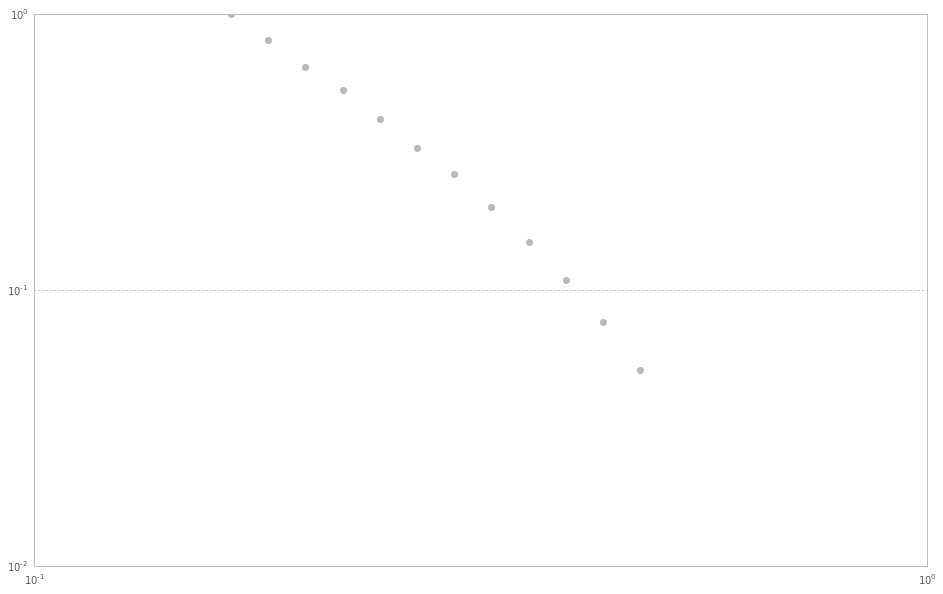

In [66]:
fig, axs = plt.subplots(1, 1, figsize=figsize) # fib
axs.set_color_cycle(np.array([[0., 1., 1.]]) * np.abs(f_bins)[:, np.newaxis])
fit_exp = np.zeros(N_orientations)
for i_theta in range(N_orientations): 
    axs.loglog((f_bins[:-1]+f_bins[1:])/2, F_rot[:, i_theta], 'o', alpha=.3)
    pars = mod.guess(F_rot[:, i_theta], x=(f_bins[:-1]+f_bins[1:])/2)
    out  = mod.fit(F_rot[:, i_theta], pars, x=(f_bins[:-1]+f_bins[1:])/2)
    fit_exp[i_theta] = -out.params.get('exponent').value
axs.axis('tight')
axs.set_xlabel('spatial frequency', **fopts)
_ = axs.set_ylabel('Power', **fopts)
inset = fig.add_axes([0.6, 0.58, .3, .3], axisbg='w')
inset.bar(theta_bins, fit_exp, width=theta_bins[1]-theta_bins[0])
inset.set_xlim((0, np.pi))
inset.set_xlabel('orientation', **fopts)
inset.set_ylabel('exponent of the best-fit \n of a power-law', fontsize=10)
fit = ((f_bins[:-1]+f_bins[1:])/2)**-fit_exp.mean()
axs.loglog((f_bins[:-1]+f_bins[1:])/2, fit/fit.max(), '-', alpha=.7)
_ = inset.annotate('Average exponent = ' + str(fit_exp.mean()), 
                   xy = (0., fit_exp.mean()), xytext = (-4.5, -3), 
                   arrowprops=dict(connectionstyle="angle,angleA=90,angleB=-180,rad=100", arrowstyle="->", lw=4, fc='b', ec='k', alpha=.2), **fopts)

Notice that the average exponent is sligthly different than the one obtained above when taking just one line or column of the spectrum, as slices in orientation are different (think of slicing a pie in a partition).

[Back to top](#SLIP)

## TODO

## more book keeping

In [67]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

Installed watermark.py. To use it, type:
  %load_ext watermark
07/04/2015 13:35:48

CPython 3.4.3
IPython 3.1.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 14.1.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [68]:
# CSS styling within IPython notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

[Back to top](#SLIP)